In [1]:
#cnet_model.ipynb 
# 
#by Joe Hahn
#joe.hahn@oracle.com
#30 July 2018
#
#train a cnet model on the XO dataset

In [2]:
#set system parameters
x_half_width = 0.5
radius = 3.5
box_half_width = 7.1
jitter = 1.0
rn_seed = 15
initial_id = 0

In [3]:
#start time
import time as tm
time_start = tm.time()

In [4]:
#adjust balance of training data so that X class is 2x more abundant that O,B
N_dots = 26700
X_boost = 2.0
import numpy as np
rn_state = np.random.RandomState(seed=rn_seed)
from helper_fns import *
df = make_xo_df(N_dots, initial_id, x_half_width, radius, box_half_width, jitter)
df = rebalance_df(df, X_boost=X_boost)
print df.groupby('class')['id'].count()
train = df
train.tail(5)

class
B    1811
O    1811
X    3623
Name: id, dtype: int64


,id,x,y,r,angle,class,X_score,O_score,B_score
7240,25304,4.369626,1.985616,4.799615,0.426518,X,1.0,0.0,0.0
7241,19432,5.590691,4.622345,7.254095,0.690866,X,1.0,0.0,0.0
7242,18541,-4.153686,5.278701,6.716977,2.237484,X,1.0,0.0,0.0
7243,1664,-0.215081,0.348915,0.409880,2.123208,O,0.0,1.0,0.0
7244,21878,-0.179858,6.556711,6.559177,1.598221,B,0.0,0.0,1.0


In [5]:
#select x-features and y = target variables = class-scores
x_cols = ['x', 'y']
y_cols = ['O_score', 'X_score', 'B_score']
x_train = train[x_cols].values
y_train = train[y_cols].values
print 'x_train.shape = ', x_train.shape
print 'y_train.shape = ', y_train.shape
x_train

x_train.shape =  (7245, 2)
y_train.shape =  (7245, 3)


array([[ 5.23040567,  2.66683096],
       [ 1.95418321, -3.44729016],
       [ 4.7309672 ,  5.27751125],
       ..., 
       [-4.15368557,  5.27870051],
       [-0.21508096,  0.34891478],
       [-0.17985751,  6.556711  ]])

In [6]:
#generate rebalanced validation data
df = make_xo_df(N_dots, initial_id, x_half_width, radius, box_half_width, jitter)
df = rebalance_df(df, X_boost=X_boost)
print df.groupby('class')['id'].count()
x_val = df[x_cols].values
y_val = df[y_cols].values
print 'x_val.shape = ', x_val.shape
print 'y_val.shape = ', y_val.shape
y_val

class
B    1813
O    1813
X    3627
Name: id, dtype: int64
x_val.shape =  (7253, 2)
y_val.shape =  (7253, 3)


array([[ 0.,  1.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       ..., 
       [ 0.,  0.,  1.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.]])

In [7]:
#helper function that builds a cnet classifier
def cnet_classifier(N_input, N_2d, kernel_size, N_output, output_activation_fn):
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, BatchNormalization, Activation, Reshape, Conv2D, MaxPooling2D, Flatten
    model = Sequential()
    #input layer
    N = N_2d**2
    input_shape = (N_input,)
    layer = Dense(N, activation='elu', input_shape=input_shape)
    model.add(layer)
    #reshape input layer
    output_shape = (N_2d, N_2d, 1)
    layer = Reshape(output_shape)
    model.add(layer)
    #add Conv2D + MaxPooling2D layers
    layer = Conv2D(1, kernel_size=kernel_size, padding='same', activation='elu')
    model.add(layer)
    pool_size = kernel_size/2
    layer = MaxPooling2D(pool_size=pool_size, strides=pool_size)
    model.add(layer)
    #add Conv2D + MaxPooling2D layers
    layer = Conv2D(1, kernel_size=kernel_size, padding='same', activation='elu')
    model.add(layer)
    layer = MaxPooling2D(pool_size=pool_size, strides=pool_size)
    model.add(layer)
    #flatten + output layer
    layer = Flatten()
    model.add(layer)
    model.add(Dense(N_output, activation=output_activation_fn))
    #set loss function
    if (output_activation_fn == 'linear'):
        loss_fn = 'mean_squared_error'
    if (output_activation_fn == 'sigmoid'):
        loss_fn = 'categorical_crossentropy'
    model.compile(loss=loss_fn, optimizer='adam')
    return model

In [8]:
#build CNET classification model 
N_input = len(x_cols)
N_2d = 100
kernel_size = 6
N_output = len(y_cols)
output_activation_fn = 'linear'
print 'N_input = ', N_input
print 'N_2d = ', N_2d
print 'kernel_size = ', kernel_size
print 'output_activation_fn = ', output_activation_fn
model = cnet_classifier(N_input, N_2d, kernel_size, N_output, output_activation_fn)
model.summary()

N_input =  2
N_2d =  100
kernel_size =  6
output_activation_fn =  linear


Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10000)             30000     
_________________________________________________________________
reshape_1 (Reshape)          (None, 100, 100, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 1)       37        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 33, 33, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 33, 33, 1)         37        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 121)               0         
__________

In [9]:
#train model...is slow on cpu...this runs 20x faster on gpu!
N_training_epochs = 15
batch_size = 2000
fit_history = model.fit(x_train, y_train, epochs=N_training_epochs, batch_size=batch_size, 
    verbose=1, validation_data=(x_val, y_val))

Train on 7245 samples, validate on 7253 samples
Epoch 1/15
7245/7245 [==============================] - 41s 6ms/step - loss: 0.2647 - val_loss: 0.2038
Epoch 2/15
7245/7245 [==============================] - 40s 6ms/step - loss: 0.2017 - val_loss: 0.1890
Epoch 3/15
7245/7245 [==============================] - 40s 6ms/step - loss: 0.1844 - val_loss: 0.1758
Epoch 4/15
7245/7245 [==============================] - 40s 5ms/step - loss: 0.1743 - val_loss: 0.1653
Epoch 5/15
7245/7245 [==============================] - 40s 6ms/step - loss: 0.1645 - val_loss: 0.1585
Epoch 6/15
7245/7245 [==============================] - 41s 6ms/step - loss: 0.1573 - val_loss: 0.1516
Epoch 7/15
7245/7245 [==============================] - 40s 6ms/step - loss: 0.1516 - val_loss: 0.1478
Epoch 8/15
7245/7245 [==============================] - 41s 6ms/step - loss: 0.1480 - val_loss: 0.1460
Epoch 9/15
7245/7245 [==============================] - 41s 6ms/step - loss: 0.1466 - val_loss: 0.1450
Epoch 10/15
7245/7245 [==

In [10]:
#prep plots
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
sns.set(font_scale=1.5, font='DejaVu Sans')

final validation loss =  0.142169761745


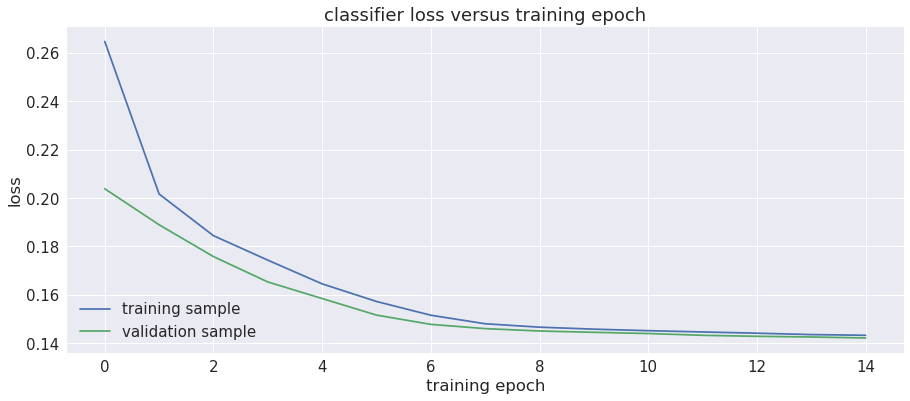

In [16]:
#plot accuracy vs training epoch
fig, ax = plt.subplots(1,1, figsize=(15, 6))
xp = fit_history.epoch
yp = fit_history.history['loss']
ax.plot(xp, yp, label='training sample')
yp = fit_history.history['val_loss']
ax.plot(xp, yp, label='validation sample')
ax.set_title('classifier loss versus training epoch')
ax.set_ylabel('loss')
ax.set_xlabel('training epoch')
ax.legend(loc='lower left')
#ax.set_ylim(0.95*np.min(yp), 1.05*np.max(yp[1:]))
plt.savefig('figs/cnet_loss.png')
print 'final validation loss = ', yp[-1]

In [12]:
#generate class predictions on testing X-O data
N_dots = 20000
df = make_xo_df(N_dots, initial_id, x_half_width, radius, box_half_width, jitter)
x = df[x_cols].values
y = df[y_cols].values
y_pred = model.predict(x)
for idx in range(len(y_cols)):
    y_col = y_cols[idx]
    df[y_col] = y_pred[:, idx]
idx = (df.O_score > df.X_score) & (df.O_score > df.B_score)
df.loc[idx, 'class_pred'] = 'O'
idx = (df.X_score > df.B_score) & (df.X_score > df.O_score)
df.loc[idx, 'class_pred'] = 'X'
idx = (df.B_score > df.O_score) & (df.B_score > df.X_score)
df.loc[idx, 'class_pred'] = 'B'
df.head(5)

,id,x,y,r,angle,class,X_score,O_score,B_score,class_pred
record,,,,,,,,,,
0,0,-2.699239,2.550202,3.713411,2.384578,X,0.707249,0.227414,0.062224,X
1,1,2.567980,-0.808677,2.692300,-0.305077,X,0.412947,0.525738,0.109206,O
2,2,4.425141,-0.676988,4.476627,-0.151810,B,0.193651,0.393644,0.432677,B
3,3,-0.256179,-4.665688,4.672716,-1.625648,B,0.156886,0.319041,0.531519,B
4,4,3.146404,0.692253,3.221656,0.216564,O,0.343950,0.509268,0.195785,O


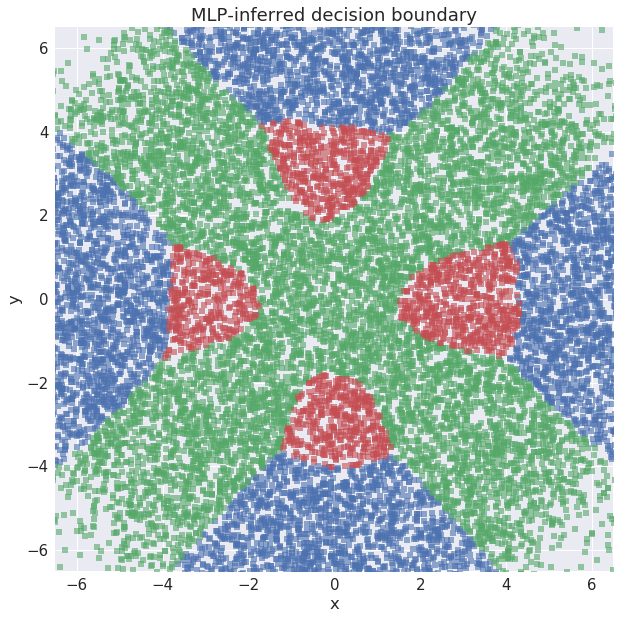

In [13]:
#scatterplot showing model's predicted decision boundaries
xy_rng = (-6.5, 6.5)
sz = 30
f, ax = plt.subplots(figsize=(10,10))
lbl = 'B'
idx = (df['class_pred'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
lbl = 'X'
idx = (df['class_pred'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
lbl = 'O'
idx = (df['class_pred'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
p = ax.set_title('MLP-inferred decision boundary')
p = ax.set_xlabel('x')
p = ax.set_ylabel('y')
p = ax.set_xlim(xy_rng)
p = ax.set_ylim(xy_rng)
plt.savefig('figs/cnet_decision_boundary.png')

In [14]:
#model accuracy
idx = (df['class'] == df['class_pred'])
accuracy = idx.sum()*1.0/len(idx)
print 'model accuracy = ', accuracy

model accuracy =  0.66555


In [15]:
#done
time_stop = tm.time()
print 'execution time (minutes) = ', (time_stop - time_start)/60.0

execution time (minutes) =  10.8563486656
